
# Methodology: Bayesian Student-t Model for S&P 500 Log Returns
**Jiang Angel · November 26, 2025 · STATS 211 – Fall 2025, Session 2**

本笔记依据讲义整理并实现 S&P 500 日对数收益的 Bayesian Student-t 建模流程。



## 1 Objective
- 目标：以 Student-t 分布刻画 S&P 500 日对数收益的厚尾行为。
- 参数：$\mu$（位置）、$\sigma^2$（尺度）、$\nu$（控制尾部厚度）。
- 方法：Metropolis-within-Gibbs 采样，Gibbs 更新 $\mu, \sigma^2$，MH 更新 $\nu$。
- 价值：Student-t 能比正态更好捕捉极端波动，为 VaR/ES 等风险指标奠定基础。



## 2 Data Preparation
1. 数据来源：`src/SP500_Log.csv`，包含日期、指数、日对数收益。
2. 清洗：剔除缺失/异常行，解析 `YYYY/MM/DD` 日期，并确保排序。
3. 对数收益：$r_t = \log(P_t / P_{t-1})$，平滑波动并满足模型假设。
4. 排序：按日期升序，防止收益错配。



### 2.1 环境与可视化工具
讲义建议 `numpy/pandas/scipy/matplotlib`。当前环境仅依赖 Python 标准库与 `IPython.display` 自定义 SVG，实现折线/直方/条形图，保证所有分布与诊断量可视化。


In [1]:

from pathlib import Path
import csv
import math
import random
import statistics
from typing import Dict, List, Tuple
from datetime import datetime
from IPython.display import SVG, display

BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / "SP500_Log.csv"
RNG_SEED = 21112025
random.seed(RNG_SEED)

print(f"当前工作目录: {BASE_DIR}")
print(f"数据文件 {DATA_PATH.name} 是否存在? {DATA_PATH.exists()}")


def _linspace(start: float, end: float, count: int) -> List[float]:
    if count <= 1:
        return [start]
    step = (end - start) / (count - 1)
    return [start + step * i for i in range(count)]


def _format_value(value: float) -> str:
    if abs(value) >= 1 or value == 0:
        return f"{value:.3f}"
    return f"{value:.4f}"


def _escape_text(text: str) -> str:
    return str(text).replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')


def plot_lines(series_list: List[Dict[str, List[float]]], x_values: List[float] = None,
               title: str = "", width: int = 900, height: int = 340,
               x_label: str = "", y_label: str = "",
               markers: List[Dict[str, float]] = None):
    if not series_list or not series_list[0]['values']:
        print('无数据可绘制')
        return
    length = len(series_list[0]['values'])
    for series in series_list:
        if len(series['values']) != length:
            raise ValueError('所有序列长度必须一致')
    if x_values is None:
        x_values = list(range(length))
    if len(x_values) != length:
        raise ValueError('x_values 长度需与序列匹配')

    y_min = min(min(s['values']) for s in series_list)
    y_max = max(max(s['values']) for s in series_list)
    if markers:
        for mk in markers:
            val = mk.get('value')
            if val is not None:
                y_min = min(y_min, val)
                y_max = max(y_max, val)
    if y_max == y_min:
        y_max += 1.0
        y_min -= 1.0

    x_min = min(x_values)
    x_max = max(x_values) if len(x_values) > 1 else x_values[0] + 1.0

    padding = 60
    inner_w = width - 2 * padding
    inner_h = height - 2 * padding

    def scale_x(x: float) -> float:
        if x_max == x_min:
            return padding + inner_w / 2.0
        return padding + (x - x_min) / (x_max - x_min) * inner_w

    def scale_y(y: float) -> float:
        return padding + inner_h - (y - y_min) / (y_max - y_min) * inner_h

    svg_parts = [f'<svg width="{width}" height="{height}" xmlns="http://www.w3.org/2000/svg" style="background:#ffffff">']
    x_axis_y = padding + inner_h
    svg_parts.append(f'<line x1="{padding}" y1="{x_axis_y}" x2="{padding + inner_w}" y2="{x_axis_y}" stroke="#333" stroke-width="1"/>')
    svg_parts.append(f'<line x1="{padding}" y1="{padding}" x2="{padding}" y2="{padding + inner_h}" stroke="#333" stroke-width="1"/>')

    for frac in _linspace(0, 1, 5):
        y_val = y_max - frac * (y_max - y_min)
        y = padding + frac * inner_h
        svg_parts.append(f'<line x1="{padding-5}" y1="{y}" x2="{padding}" y2="{y}" stroke="#333"/>')
        svg_parts.append(f'<text x="{padding-8}" y="{y+4}" text-anchor="end" font-size="10" fill="#333">{_format_value(y_val)}</text>')

        x_val = x_min + frac * (x_max - x_min)
        x = padding + frac * inner_w
        svg_parts.append(f'<line x1="{x}" y1="{x_axis_y}" x2="{x}" y2="{x_axis_y+5}" stroke="#333"/>')
        svg_parts.append(f'<text x="{x}" y="{x_axis_y+18}" text-anchor="middle" font-size="10" fill="#333">{_format_value(x_val)}</text>')

    for idx, series in enumerate(series_list):
        color = series.get('color', '#1f77b4')
        width_line = series.get('stroke_width', 2)
        values = series['values']
        path_cmds = []
        for i, val in enumerate(values):
            x = scale_x(x_values[i])
            y = scale_y(val)
            cmd = 'M' if i == 0 else 'L'
            path_cmds.append(f'{cmd}{x:.2f},{y:.2f}')
        path_cmds_str = ' '.join(path_cmds)
        svg_parts.append(f'<path d="{path_cmds_str}" fill="none" stroke="{color}" stroke-width="{width_line}"/>')
        label = series.get('label')
        if label:
            legend_x = padding + inner_w - 180
            legend_y = padding + 15 + idx * 18
            svg_parts.append(f'<line x1="{legend_x}" y1="{legend_y}" x2="{legend_x+22}" y2="{legend_y}" stroke="{color}" stroke-width="3"/>')
            svg_parts.append(f'<text x="{legend_x+28}" y="{legend_y+4}" font-size="10" fill="#333">{_escape_text(label)}</text>')

    if markers:
        for mk in markers:
            val = mk.get('value')
            if val is None:
                continue
            color = mk.get('color', '#d62728')
            label = mk.get('label', '')
            y = scale_y(val)
            svg_parts.append(f'<line x1="{padding}" y1="{y}" x2="{padding+inner_w}" y2="{y}" stroke="{color}" stroke-dasharray="4 3"/>')
            if label:
                svg_parts.append(f'<text x="{padding+inner_w+5}" y="{y+4}" font-size="10" fill="{color}" text-anchor="start">{_escape_text(label)} ({val:.4f})</text>')

    if title:
        svg_parts.append(f'<text x="{width/2}" y="20" text-anchor="middle" font-size="14" fill="#111">{_escape_text(title)}</text>')
    if y_label:
        svg_parts.append(f'<text x="15" y="{height/2}" transform="rotate(-90 15,{height/2})" text-anchor="middle" font-size="11" fill="#111">{_escape_text(y_label)}</text>')
    if x_label:
        svg_parts.append(f'<text x="{width/2}" y="{height-10}" text-anchor="middle" font-size="11" fill="#111">{_escape_text(x_label)}</text>')
    svg_parts.append('</svg>')
    display(SVG('\\n'.join(svg_parts)))


def plot_hist(values: List[float], bins: int = 20, title: str = "",
              width: int = 900, height: int = 340, color: str = "#ff7f0e",
              x_label: str = "", y_label: str = "密度",
              markers: List[Dict[str, float]] = None):
    if not values:
        print('无数据可绘制')
        return
    v_min = min(values)
    v_max = max(values)
    if v_max == v_min:
        v_max += 1.0
        v_min -= 1.0
    bin_width = (v_max - v_min) / bins
    counts = [0 for _ in range(bins)]
    for val in values:
        idx = int((val - v_min) / bin_width)
        if idx == bins:
            idx -= 1
        counts[idx] += 1
    densities = [c / (len(values) * bin_width) for c in counts]
    d_max = max(densities)
    padding = 60
    inner_w = width - 2 * padding
    inner_h = height - 2 * padding

    def scale_x(x: float) -> float:
        return padding + (x - v_min) / (v_max - v_min) * inner_w

    svg_parts = [f'<svg width="{width}" height="{height}" xmlns="http://www.w3.org/2000/svg" style="background:#ffffff">']
    base_y = padding + inner_h
    svg_parts.append(f'<line x1="{padding}" y1="{base_y}" x2="{padding + inner_w}" y2="{base_y}" stroke="#333" stroke-width="1"/>')
    svg_parts.append(f'<line x1="{padding}" y1="{padding}" x2="{padding}" y2="{padding + inner_h}" stroke="#333" stroke-width="1"/>')

    for frac in _linspace(0, 1, 5):
        density_val = d_max * (1 - frac)
        y = padding + frac * inner_h
        svg_parts.append(f'<line x1="{padding-5}" y1="{y}" x2="{padding}" y2="{y}" stroke="#333"/>')
        svg_parts.append(f'<text x="{padding-8}" y="{y+4}" text-anchor="end" font-size="10" fill="#333">{density_val:.3f}</text>')

        x_val = v_min + frac * (v_max - v_min)
        x = padding + frac * inner_w
        svg_parts.append(f'<line x1="{x}" y1="{base_y}" x2="{x}" y2="{base_y+5}" stroke="#333"/>')
        svg_parts.append(f'<text x="{x}" y="{base_y+18}" text-anchor="middle" font-size="10" fill="#333">{_format_value(x_val)}</text>')

    bar_width = inner_w / bins
    for i, density in enumerate(densities):
        bar_height = 0 if d_max == 0 else density / d_max * inner_h
        x0 = padding + i * bar_width
        y0 = base_y - bar_height
        svg_parts.append(f'<rect x="{x0}" y="{y0}" width="{bar_width - 1}" height="{bar_height}" fill="{color}" opacity="0.7"/>')

    if markers:
        for mk in markers:
            val = mk.get('value')
            if val is None:
                continue
            x = scale_x(val)
            label = mk.get('label', '')
            mk_color = mk.get('color', '#d62728')
            svg_parts.append(f'<line x1="{x}" y1="{padding}" x2="{x}" y2="{padding+inner_h}" stroke="{mk_color}" stroke-dasharray="4 3"/>')
            if label:
                svg_parts.append(f'<text x="{x+5}" y="{padding+15}" font-size="10" fill="{mk_color}">{_escape_text(label)} ({val:.4f})</text>')

    if title:
        svg_parts.append(f'<text x="{width/2}" y="20" text-anchor="middle" font-size="14" fill="#111">{_escape_text(title)}</text>')
    if y_label:
        svg_parts.append(f'<text x="15" y="{height/2}" transform="rotate(-90 15,{height/2})" text-anchor="middle" font-size="11" fill="#111">{_escape_text(y_label)}</text>')
    if x_label:
        svg_parts.append(f'<text x="{width/2}" y="{height-10}" text-anchor="middle" font-size="11" fill="#111">{_escape_text(x_label)}</text>')
    svg_parts.append('</svg>')
    display(SVG('\\n'.join(svg_parts)))


def plot_bars(values: List[float], title: str = "", width: int = 900, height: int = 320,
              color: str = "#9467bd", x_label: str = "", y_label: str = "值"):
    if not values:
        print('无数据可绘制')
        return
    padding = 60
    inner_w = width - 2 * padding
    inner_h = height - 2 * padding

    y_min = min(min(values), 0.0)
    y_max = max(max(values), 0.0)
    if y_max == y_min:
        y_max = y_min + 1.0
    n = len(values)
    bar_width = inner_w / n

    def scale_y(val: float) -> float:
        return padding + inner_h - (val - y_min) / (y_max - y_min) * inner_h

    base_y = scale_y(0.0)
    svg_parts = [f'<svg width="{width}" height="{height}" xmlns="http://www.w3.org/2000/svg" style="background:#ffffff">']
    svg_parts.append(f'<line x1="{padding}" y1="{base_y}" x2="{padding + inner_w}" y2="{base_y}" stroke="#333" stroke-width="1"/>')
    svg_parts.append(f'<line x1="{padding}" y1="{padding}" x2="{padding}" y2="{padding + inner_h}" stroke="#333" stroke-width="1"/>')

    for frac in _linspace(0, 1, 5):
        y_val = y_max - frac * (y_max - y_min)
        y = padding + frac * inner_h
        svg_parts.append(f'<line x1="{padding-5}" y1="{y}" x2="{padding}" y2="{y}" stroke="#333"/>')
        svg_parts.append(f'<text x="{padding-8}" y="{y+4}" text-anchor="end" font-size="10" fill="#333">{_format_value(y_val)}</text>')

    for idx, val in enumerate(values):
        x0 = padding + idx * bar_width
        height_bar = abs(scale_y(val) - base_y)
        if val >= 0:
            svg_parts.append(f'<rect x="{x0}" y="{scale_y(val)}" width="{bar_width-2}" height="{height_bar}" fill="{color}" opacity="0.8"/>')
        else:
            svg_parts.append(f'<rect x="{x0}" y="{base_y}" width="{bar_width-2}" height="{height_bar}" fill="{color}" opacity="0.8"/>')
        svg_parts.append(f'<text x="{x0 + bar_width/2}" y="{base_y+15}" text-anchor="middle" font-size="9" fill="#333">{idx+1}</text>')

    if title:
        svg_parts.append(f'<text x="{width/2}" y="20" text-anchor="middle" font-size="14" fill="#111">{_escape_text(title)}</text>')
    if y_label:
        svg_parts.append(f'<text x="15" y="{height/2}" transform="rotate(-90 15,{height/2})" text-anchor="middle" font-size="11" fill="#111">{_escape_text(y_label)}</text>')
    if x_label:
        svg_parts.append(f'<text x="{width/2}" y="{height-10}" text-anchor="middle" font-size="11" fill="#111">{_escape_text(x_label)}</text>')
    svg_parts.append('</svg>')
    display(SVG('\\n'.join(svg_parts)))


def percentile(values: List[float], q: float) -> float:
    if not values:
        raise ValueError('空序列无法计算分位数')
    if q <= 0:
        return min(values)
    if q >= 1:
        return max(values)
    ordered = sorted(values)
    pos = (len(ordered) - 1) * q
    low = math.floor(pos)
    high = math.ceil(pos)
    if low == high:
        return ordered[int(pos)]
    weight = pos - low
    return ordered[low] + (ordered[high] - ordered[low]) * weight


def describe_series(values: List[float]) -> Dict[str, float]:
    mean_val = sum(values) / len(values)
    variance = sum((x - mean_val) ** 2 for x in values) / (len(values) - 1)
    stdev = math.sqrt(variance)
    return {
        'mean': mean_val,
        'stdev': stdev,
        'min': min(values),
        'max': max(values),
        'q05': percentile(values, 0.05),
        'q50': percentile(values, 0.5),
        'q95': percentile(values, 0.95),
        'annualized_vol': stdev * math.sqrt(252),
    }


def autocorr(series: List[float], lag: int) -> float:
    n = len(series)
    if lag <= 0 or lag >= n:
        return 0.0
    mean_val = sum(series) / n
    var = sum((x - mean_val) ** 2 for x in series) / n
    if var == 0:
        return 0.0
    cov = sum((series[i] - mean_val) * (series[i + lag] - mean_val) for i in range(n - lag)) / n
    return cov / var


def student_t_pdf(x: float, mu: float, sigma2: float, nu: float) -> float:
    norm = math.exp(math.lgamma((nu + 1.0) / 2.0) - math.lgamma(nu / 2.0))
    denom = math.sqrt(math.pi * nu * sigma2)
    inner = 1.0 + ((x - mu) ** 2) / (nu * sigma2)
    return norm / denom * inner ** (-(nu + 1.0) / 2.0)


def normal_pdf(x: float, mu: float, sigma2: float) -> float:
    denom = math.sqrt(2.0 * math.pi * sigma2)
    exponent = -0.5 * ((x - mu) ** 2) / sigma2
    return math.exp(exponent) / denom


def gamma_pdf(x: float, shape: float, rate: float) -> float:
    if x <= 0:
        return 0.0
    log_pdf = shape * math.log(rate) - math.lgamma(shape) + (shape - 1.0) * math.log(x) - rate * x
    return math.exp(min(log_pdf, 50.0))


def inverse_gamma_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0:
        return 0.0
    log_pdf = alpha * math.log(beta) - math.lgamma(alpha) - (alpha + 1.0) * math.log(x) - beta / x
    return math.exp(min(log_pdf, 50.0))


当前工作目录: /Users/apple/Tlhey_folders/Year_4/Stats211/proj/STATS211_Project
数据文件 SP500_Log.csv 是否存在? False



### 2.2 数据加载与排序检查
读取 `SP500_Log.csv`，校验日期排序并展示基础统计与可视化。


In [2]:

from pprint import pprint


def load_sp500_records(csv_path: Path) -> List[Dict[str, float]]:
    records: List[Dict[str, float]] = []
    with csv_path.open('r', encoding='utf-8') as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            date_str = row.get('observation_date', '')
            price_str = row.get('SP500', '')
            log_ret_str = row.get('log_return', '')
            if not date_str or not price_str or not log_ret_str:
                continue
            try:
                price = float(price_str)
                log_ret = float(log_ret_str)
                date_obj = datetime.strptime(date_str, '%Y/%m/%d')
            except ValueError:
                continue
            records.append({
                'date_str': date_str,
                'date_obj': date_obj,
                'index_level': price,
                'log_return': log_ret,
            })
    return records


raw_records = load_sp500_records(DATA_PATH)
sorted_records = sorted(raw_records, key=lambda item: item['date_obj'])
if raw_records != sorted_records:
    print('原始文件未严格按日期排序，已在内存中重新排序。')
records = sorted_records

log_returns = [item['log_return'] for item in records]
index_levels = [item['index_level'] for item in records]
dates = [item['date_str'] for item in records]

print(f"记录总数: {len(records)}")
if dates:
    print(f"日期范围: {dates[0]} -> {dates[-1]}")

return_stats = describe_series(log_returns)
print('对数收益统计:')
for key in ['mean', 'stdev', 'min', 'max', 'q05', 'q50', 'q95', 'annualized_vol']:
    print(f"  {key:>12s}: {return_stats[key]: .6f}")

print('前 5 条记录:')
for sample in records[:5]:
    pprint(sample)

plot_lines(
    [{'values': index_levels, 'label': 'S&P 500 收盘价', 'color': '#1f77b4'}],
    x_values=list(range(len(index_levels))),
    title='S&P 500 收盘价序列',
    x_label='样本序号',
    y_label='指数点位',
)

plot_lines(
    [{'values': log_returns, 'label': '日对数收益', 'color': '#d62728'}],
    x_values=list(range(len(log_returns))),
    title='日对数收益序列',
    x_label='样本序号',
    y_label='收益',
    markers=[{'value': 0.0, 'label': '零收益', 'color': '#555555'}],
)

plot_hist(
    log_returns,
    bins=30,
    title='日对数收益直方图',
    x_label='收益',
    color='#ff7f0e',
)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/apple/Tlhey_folders/Year_4/Stats211/proj/STATS211_Project/SP500_Log.csv'


## 3 Statistical Model
假设 $y_i \mid \mu, \sigma^2, \nu \sim t_{\nu}(\mu, \sigma^2)$，厚尾由 $\nu$ 控制，$\nu \to \infty$ 时回到正态。



### 3.1 Scale Mixture Representation
Student-t 可视为正态- Gamma 混合：$y_i \mid \lambda_i \sim \mathcal{N}(\mu, \sigma^2/\lambda_i)$，$\lambda_i \sim \text{Gamma}(\nu/2, \nu/2)$，便于 Gibbs 更新。


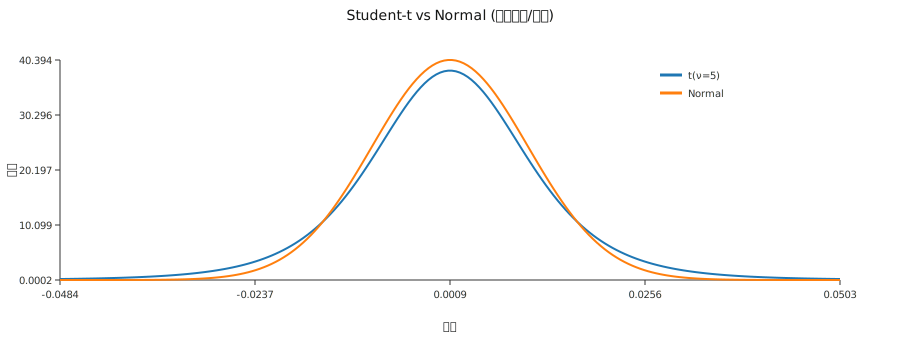

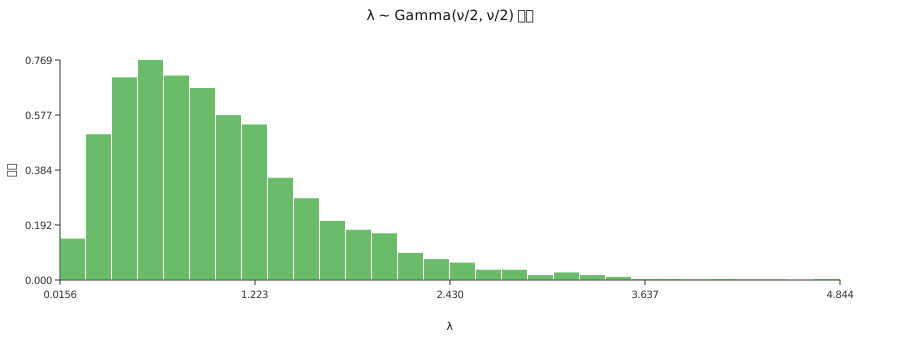

In [ ]:

if log_returns:
    mu_demo = return_stats['mean']
    sigma2_demo = statistics.pvariance(log_returns)
    nu_demo = 5.0
    grid = _linspace(mu_demo - 5 * math.sqrt(sigma2_demo), mu_demo + 5 * math.sqrt(sigma2_demo), 200)
    t_pdf = [student_t_pdf(x, mu_demo, sigma2_demo, nu_demo) for x in grid]
    normal_pdf_vals = [normal_pdf(x, mu_demo, sigma2_demo) for x in grid]
    plot_lines(
        [
            {'values': t_pdf, 'label': f't(ν={nu_demo:.0f})', 'color': '#1f77b4'},
            {'values': normal_pdf_vals, 'label': 'Normal', 'color': '#ff7f0e'},
        ],
        x_values=grid,
        title='Student-t vs Normal (经验均值/方差)',
        x_label='收益',
        y_label='密度',
    )

    demo_rng = random.Random(1234)
    lambda_draws = [demo_rng.gammavariate(nu_demo / 2.0, 2.0 / nu_demo) for _ in range(4000)]
    plot_hist(
        lambda_draws,
        bins=30,
        title='λ ~ Gamma(ν/2, ν/2) 示例',
        x_label='λ',
        color='#2ca02c',
    )



## 4 Prior Specification
$\mu \sim \mathcal{N}(m_0, \sigma^2/\kappa_0)$，$\sigma^2 \sim \text{Inv-Gamma}(\alpha_0, \beta_0)$，$\nu \sim \text{Gamma}(a_0, b_0)$，可选约束 $\nu>2$ 以保证有限方差。


In [ ]:

priors = {
    'm0': 0.0,
    'kappa0': 1e-4,
    'alpha0': 2.5,
    'beta0': 0.002,
    'a0': 2.5,
    'b0': 0.2,
    'nu_gt2': True,
}
print('先验超参数:')
for key, val in priors.items():
    print(f"  {key:>7s} = {val}")


先验超参数:
       m0 = 0.0
   kappa0 = 0.0001
   alpha0 = 2.5
    beta0 = 0.002
       a0 = 2.5
       b0 = 0.2
   nu_gt2 = True



## 5 Metropolis-within-Gibbs Sampling
1. 采样 $\lambda_i$：Gamma 条件后验。
2. 更新 $\mu$：$\kappa_n = \kappa_0 + \sum \lambda_i$，$m_n = (\kappa_0 m_0 + \sum \lambda_i y_i)/\kappa_n$，$\mu \sim \mathcal{N}(m_n, \sigma^2/\kappa_n)$。
3. 更新 $\sigma^2$：$\alpha_n = \alpha_0 + n/2$，$\beta_n = \beta_0 + 0.5\sum \lambda_i(y_i-\mu)^2$，$\sigma^2 \sim \text{Inv-Gamma}(\alpha_n, \beta_n)$。
4. 更新 $\nu$：在对数（或对数移位）空间提案，MH 接受率包含 Gamma 先验与雅可比，自适应提案标准差以保持约 30% 接受率。


In [ ]:

def log_prior_nu(nu: float, a0: float, b0: float, shift: float) -> float:
    if nu <= shift:
        return float('-inf')
    z = nu - shift
    return a0 * math.log(b0) - math.lgamma(a0) + (a0 - 1.0) * math.log(z) - b0 * z


def log_lambda_likelihood(nu: float, lambdas: List[float]) -> float:
    if nu <= 0:
        return float('-inf')
    half = 0.5 * nu
    log_norm = half * math.log(half) - math.lgamma(half)
    sum_log_lambda = sum(math.log(lmbd) for lmbd in lambdas)
    sum_lambda = sum(lambdas)
    n = len(lambdas)
    return n * log_norm + (half - 1.0) * sum_log_lambda - 0.5 * nu * sum_lambda


def log_target_nu(nu: float, lambdas: List[float], a0: float, b0: float, shift: float) -> float:
    return log_prior_nu(nu, a0, b0, shift) + log_lambda_likelihood(nu, lambdas)


def summarize_posterior(samples: List[Dict[str, float]], key: str) -> Dict[str, float]:
    values = [s[key] for s in samples]
    return {
        'mean': sum(values) / len(values),
        'median': percentile(values, 0.5),
        'ci_lower': percentile(values, 0.025),
        'ci_upper': percentile(values, 0.975),
    }


def run_sampler(
    returns: List[float],
    iterations: int = 9000,
    burn_in: int = 3000,
    thin: int = 6,
    m0: float = 0.0,
    kappa0: float = 1e-4,
    alpha0: float = 2.5,
    beta0: float = 0.002,
    a0: float = 2.5,
    b0: float = 0.2,
    nu_gt2: bool = True,
    proposal_sd: float = 0.25,
    adapt_start: int = 800,
    adapt_end: int = 2500,
    target_accept: float = 0.3,
    seed: int = 2025,
) -> Tuple[List[Dict[str, float]], Dict[str, float]]:
    rng = random.Random(seed)
    n = len(returns)
    mu = statistics.mean(returns)
    sigma2 = statistics.pvariance(returns)
    nu = 8.0
    lambdas = [1.0 for _ in returns]
    saved: List[Dict[str, float]] = []
    accepts = 0
    rw_steps = 0
    prop_sd = proposal_sd
    shift = 2.0 if nu_gt2 else 0.0

    for it in range(iterations):
        for idx, ret in enumerate(returns):
            diff = ret - mu
            shape = 0.5 * (nu + 1.0)
            rate = 0.5 * (nu + (diff * diff) / max(sigma2, 1e-12))
            scale = 1.0 / rate
            lambdas[idx] = rng.gammavariate(shape, scale)

        sum_lambda = sum(lambdas)
        weighted_sum = sum(l * r for l, r in zip(lambdas, returns))

        kappa_n = kappa0 + sum_lambda
        mu_mean = (kappa0 * m0 + weighted_sum) / kappa_n
        mu_sd = math.sqrt(max(sigma2 / kappa_n, 1e-12))
        mu = rng.gauss(mu_mean, mu_sd)

        alpha_n = alpha0 + 0.5 * n
        beta_n = beta0 + 0.5 * sum(l * (r - mu) ** 2 for l, r in zip(lambdas, returns))
        gamma_draw = rng.gammavariate(alpha_n, 1.0 / max(beta_n, 1e-12))
        sigma2 = 1.0 / gamma_draw

        rw_steps += 1
        eta_curr = math.log(nu - shift)
        eta_prop = rng.gauss(eta_curr, prop_sd)
        nu_prop = shift + math.exp(eta_prop)
        log_target_prop = log_target_nu(nu_prop, lambdas, a0, b0, shift)
        log_target_curr = log_target_nu(nu, lambdas, a0, b0, shift)
        log_ratio = (log_target_prop + eta_prop) - (log_target_curr + eta_curr)
        if math.log(rng.random()) < log_ratio:
            nu = nu_prop
            accepts += 1

        if adapt_start <= it < adapt_end:
            acc_rate = accepts / max(rw_steps, 1)
            adjust = math.exp(0.05 * (acc_rate - target_accept))
            prop_sd = max(0.05, min(1.5, prop_sd * adjust))

        if it >= burn_in and (it - burn_in) % thin == 0:
            saved.append({'mu': mu, 'sigma2': sigma2, 'nu': nu})

    diagnostics = {
        'acceptance_rate': accepts / max(rw_steps, 1),
        'final_proposal_sd': prop_sd,
        'lambda_snapshot': list(lambdas),
    }
    return saved, diagnostics


sampler_config = {
    'iterations': 9000,
    'burn_in': 3000,
    'thin': 6,
    'm0': priors['m0'],
    'kappa0': priors['kappa0'],
    'alpha0': priors['alpha0'],
    'beta0': priors['beta0'],
    'a0': priors['a0'],
    'b0': priors['b0'],
    'nu_gt2': priors['nu_gt2'],
    'proposal_sd': 0.25,
    'adapt_start': 800,
    'adapt_end': 2500,
    'target_accept': 0.3,
    'seed': 2025,
}

posterior_samples, sampler_info = run_sampler(log_returns, **sampler_config)
print(f"保存的后验样本数: {len(posterior_samples)}")
print(f"ν 的 MH 接受率: {sampler_info['acceptance_rate']:.2%}")
print(f"自适应后的提案标准差: {sampler_info['final_proposal_sd']:.3f}")

posterior_mu = [s['mu'] for s in posterior_samples]
posterior_sigma2 = [s['sigma2'] for s in posterior_samples]
posterior_nu = [s['nu'] for s in posterior_samples]
param_summaries = {
    'mu': summarize_posterior(posterior_samples, 'mu'),
    'sigma2': summarize_posterior(posterior_samples, 'sigma2'),
    'nu': summarize_posterior(posterior_samples, 'nu'),
}
for key, stats in param_summaries.items():
    print(f"{key:>6s} -> mean={stats['mean']:.6f}, 95% CI=({stats['ci_lower']:.6f}, {stats['ci_upper']:.6f})")


保存的后验样本数: 1000
ν 的 MH 接受率: 42.54%
自适应后的提案标准差: 0.166
    mu -> mean=0.001131, 95% CI=(0.000503, 0.001783)
sigma2 -> mean=0.000060, 95% CI=(0.000051, 0.000069)
    nu -> mean=5.655980, 95% CI=(4.113586, 7.738728)



## 6 Convergence Diagnostics
查看轨迹、后验直方图、ACF 以及 $\lambda$ 的分布，以检验链条混合情况。


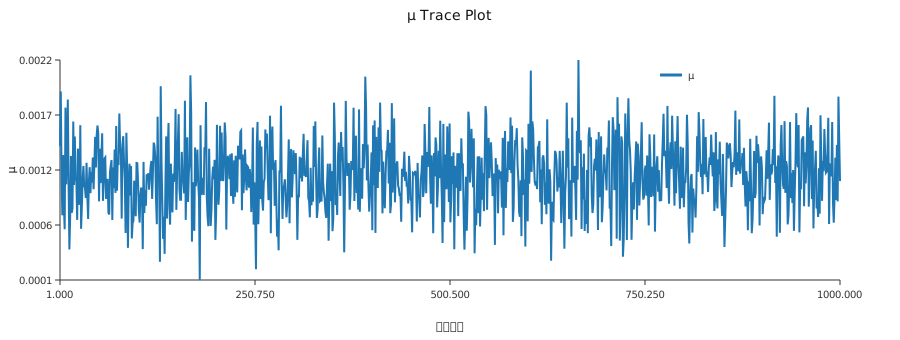

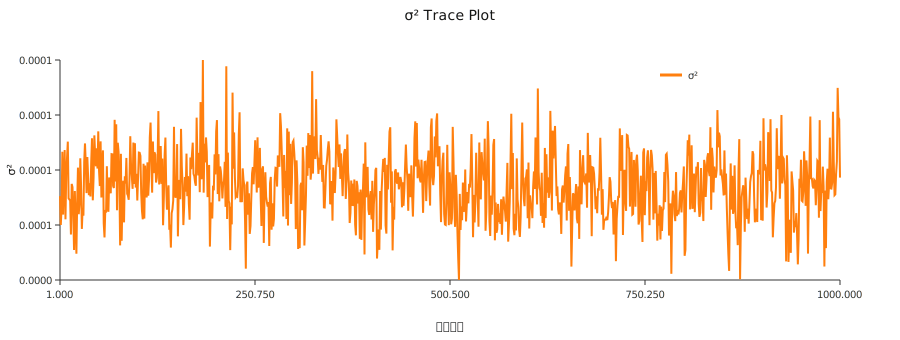

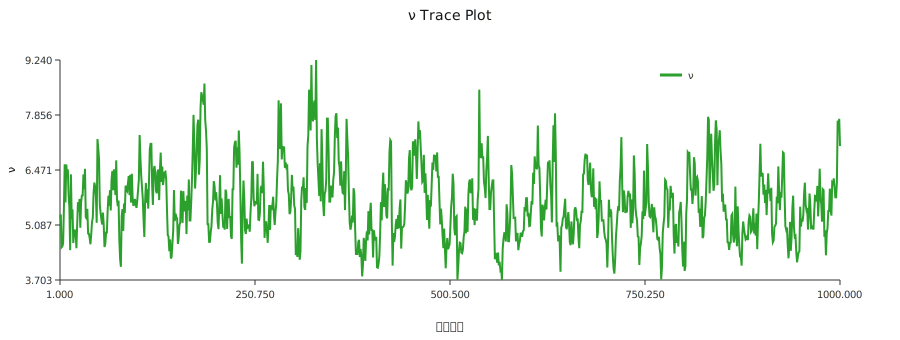

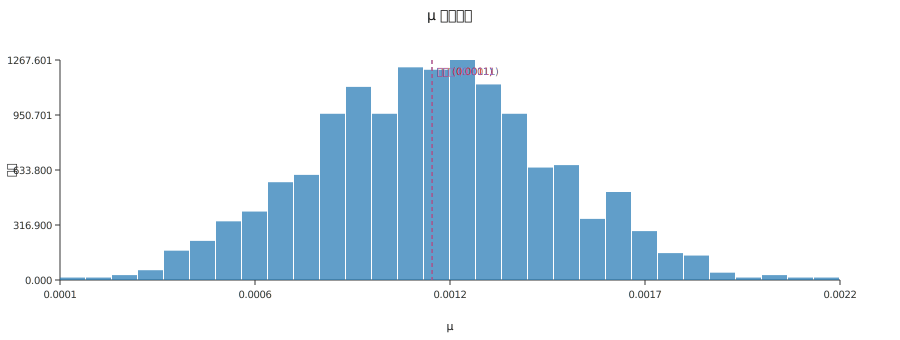

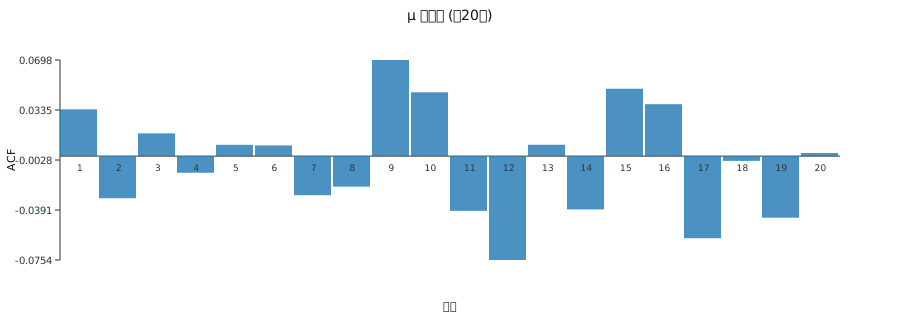

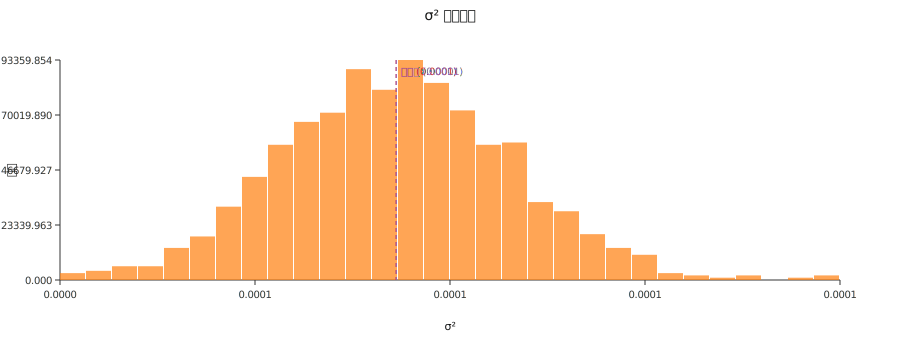

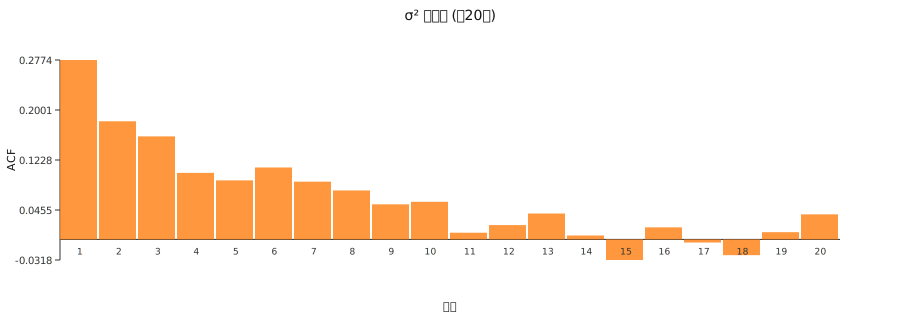

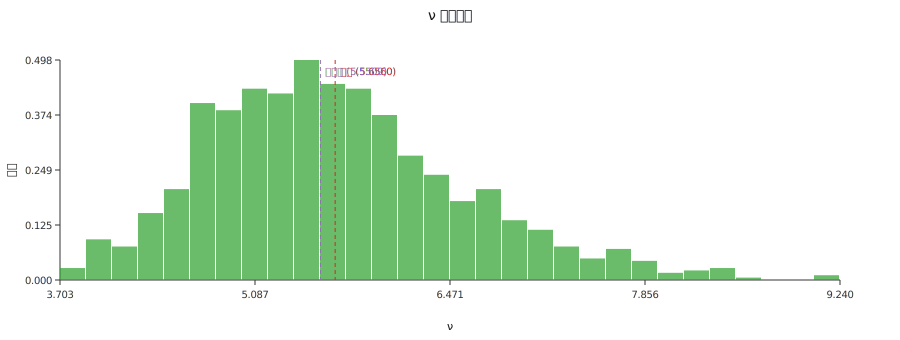

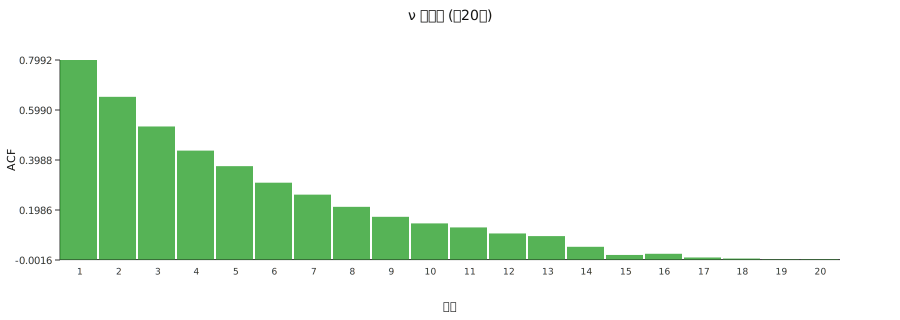

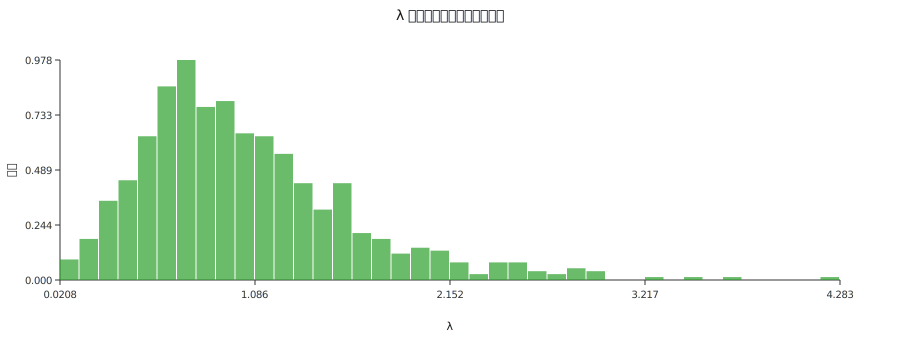

In [ ]:

trace_index = list(range(1, len(posterior_mu) + 1))
plot_lines(
    [{'values': posterior_mu, 'label': 'μ', 'color': '#1f77b4'}],
    x_values=trace_index,
    title='μ Trace Plot',
    x_label='样本编号',
    y_label='μ',
)
plot_lines(
    [{'values': posterior_sigma2, 'label': 'σ²', 'color': '#ff7f0e'}],
    x_values=trace_index,
    title='σ² Trace Plot',
    x_label='样本编号',
    y_label='σ²',
)
plot_lines(
    [{'values': posterior_nu, 'label': 'ν', 'color': '#2ca02c'}],
    x_values=trace_index,
    title='ν Trace Plot',
    x_label='样本编号',
    y_label='ν',
)

mapping = [('μ', 'mu', posterior_mu, '#1f77b4'), ('σ²', 'sigma2', posterior_sigma2, '#ff7f0e'), ('ν', 'nu', posterior_nu, '#2ca02c')]
for label, key, values, color in mapping:
    if not values:
        continue
    summary = param_summaries[key]
    plot_hist(
        values,
        bins=30,
        title=f'{label} 后验分布',
        x_label=label,
        color=color,
        markers=[
            {'value': summary['mean'], 'label': '均值', 'color': '#d62728'},
            {'value': summary['median'], 'label': '中位数', 'color': '#9467bd'},
        ],
    )
    acf_vals = [autocorr(values, lag) for lag in range(1, 21)]
    plot_bars(
        acf_vals,
        title=f'{label} 自相关 (前20阶)',
        x_label='滞后',
        y_label='ACF',
        color=color,
    )

lambda_snapshot = sampler_info['lambda_snapshot']
if lambda_snapshot:
    plot_hist(
        lambda_snapshot,
        bins=40,
        title='λ 条件分布（最近一次迭代）',
        x_label='λ',
        color='#2ca02c',
    )



## 7 Posterior Summaries
报告均值/中位数/95% CI，并基于后验均值绘制 Student-t 与正态、σ²、ν 的密度示意。


μ: mean=0.001131, median=0.001130, 95% CI=(0.000503, 0.001783)
σ²: mean=0.000060, median=0.000060, 95% CI=(0.000051, 0.000069)
ν: mean=5.655980, median=5.550884, 95% CI=(4.113586, 7.738728)


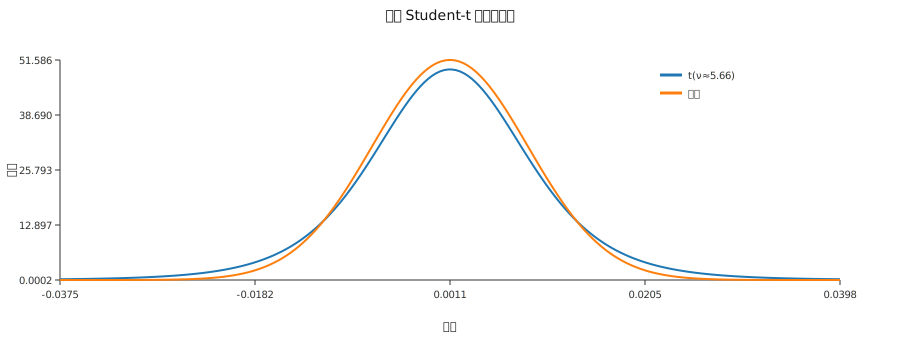

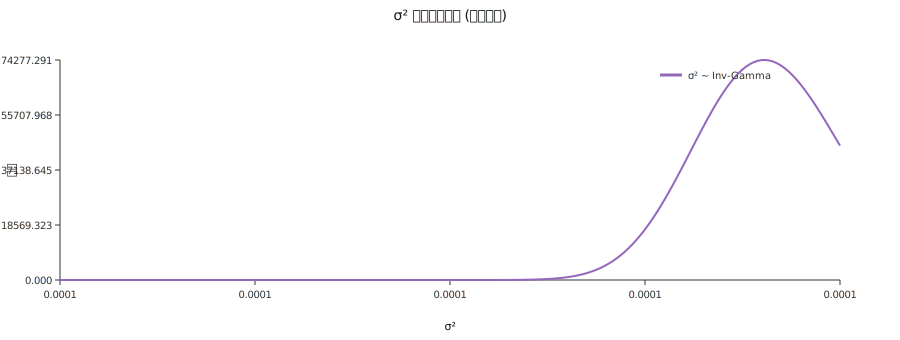

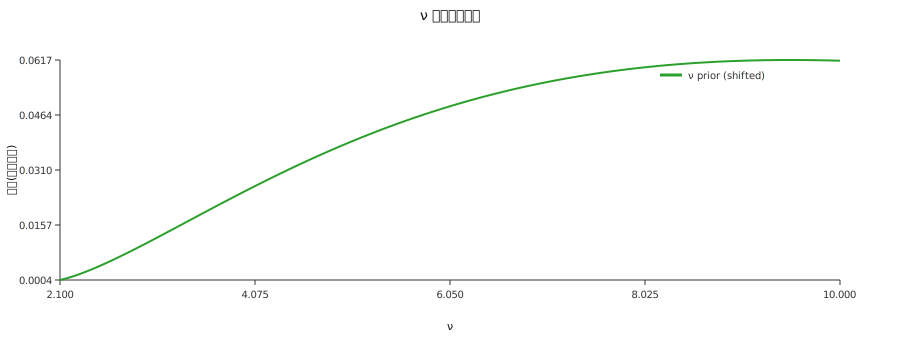

In [ ]:

for key, label in [('mu', 'μ'), ('sigma2', 'σ²'), ('nu', 'ν')]:
    stats = param_summaries[key]
    print(f"{label}: mean={stats['mean']:.6f}, median={stats['median']:.6f}, 95% CI=({stats['ci_lower']:.6f}, {stats['ci_upper']:.6f})")

mu_hat = param_summaries['mu']['mean']
sigma2_hat = param_summaries['sigma2']['mean']
nu_hat = param_summaries['nu']['mean']
grid = _linspace(mu_hat - 5 * math.sqrt(sigma2_hat), mu_hat + 5 * math.sqrt(sigma2_hat), 200)
t_pdf_hat = [student_t_pdf(x, mu_hat, sigma2_hat, nu_hat) for x in grid]
normal_pdf_hat = [normal_pdf(x, mu_hat, sigma2_hat) for x in grid]
plot_lines(
    [
        {'values': t_pdf_hat, 'label': f't(ν≈{nu_hat:.2f})', 'color': '#1f77b4'},
        {'values': normal_pdf_hat, 'label': '正态', 'color': '#ff7f0e'},
    ],
    x_values=grid,
    title='后验 Student-t 与正态比较',
    x_label='收益',
    y_label='密度',
)

alpha_post = priors['alpha0'] + 0.5 * len(log_returns)
beta_post = priors['beta0'] + 0.5 * sum((r - mu_hat) ** 2 for r in log_returns)
sigma_min = max(param_summaries['sigma2']['ci_lower'], sigma2_hat * 0.5)
sigma_max = max(param_summaries['sigma2']['ci_upper'], sigma2_hat * 1.8)
if sigma_max <= sigma_min:
    sigma_max = sigma_min * 1.5
sigma_grid = _linspace(sigma_min, sigma_max, 200)
inv_gamma_vals = [inverse_gamma_pdf(x, alpha_post, beta_post) for x in sigma_grid]
plot_lines(
    [{'values': inv_gamma_vals, 'label': 'σ² ~ Inv-Gamma', 'color': '#9467bd'}],
    x_values=sigma_grid,
    title='σ² 条件分布形状 (后验参数)',
    x_label='σ²',
    y_label='密度',
)

nu_grid = _linspace(2.1, max(param_summaries['nu']['ci_upper'], 10.0), 200)
nu_pdf_vals = [gamma_pdf(x - 2.0, priors['a0'], priors['b0']) if priors['nu_gt2'] else gamma_pdf(x, priors['a0'], priors['b0']) for x in nu_grid]
plot_lines(
    [{'values': nu_pdf_vals, 'label': 'ν prior (shifted)', 'color': '#2ca02c'}],
    x_values=nu_grid,
    title='ν 先验形状示意',
    x_label='ν',
    y_label='密度(未归一化)',
)



## 8 Parameter Tuning and Effects
| 参数 | 角色 | 调整影响 |
| --- | --- | --- |
| `proposal_sd` | ν 的 MH 步长 | ↑步长 → 接受率下降但探索更快；↓步长 → 接受率上升但混合变慢 |
| `adapt_start/end` | 自适应窗口 | 过早易震荡，过晚适应不足 |
| `burn_in` | Burn-in | 太短残留初始偏差，太长浪费样本 |
| `m0`, `kappa0` | μ 先验 | 大 `kappa0` 表示强先验，小值让数据主导 |
| `alpha0`, `beta0` | σ² 先验 | 大值压缩波动率，小值放松限制 |
| `a0`, `b0` | ν 先验 | 控制尾部厚度，弱先验更依赖数据 |
| `nu_gt2` | 约束 | 保证有限方差，可能低估极端厚尾 |
| `iterations/thin` | 迭代/抽样 | 更多迭代平滑后验，抽样间隔降低图形噪声 |



## 9 Implementation Details
- Python 3 标准库 + `IPython.display` 自绘 SVG，满足无外部依赖的限制。
- 输入：`SP500_Log.csv`；输出：数据可视化、MCMC 诊断、后验汇总。
- 可重复性：固定 `RNG_SEED` 与采样器 `seed`，便于复现与调参。



### 9.1 Update of ν (Degrees of Freedom)
- 对数提案：若 `nu_gt2=True` 则使用 $\log(\nu-2)$，并在 MH 比率中包含雅可比。
- 接受率：$\alpha = \min\{1, p(\nu_{prop}\mid\lambda)/p(\nu_{curr}\mid\lambda) \cdot J_{prop}/J_{curr}\}$，其中 $p$ 含先验与似然项。
- 自适应：根据累计接受率调整 `proposal_sd`，目标约 30%。
- 抽稀：为图形可读性对 ν 链条抽稀，但统计量使用全部样本。
- 直觉：ν 小 → 厚尾；自适应 MH 让链条在“厚尾”与“近正态”之间自如游走。
